In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tqdm import tqdm

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# load the dataset here
# only the top 10k words
max_features = 10000
maxlen = 100  

In [4]:
(X_train_val, y_train_val), (X_test, y_test) = imdb.load_data(num_words=max_features)


In [5]:
# pad sequencing
X_train_val = pad_sequences(X_train_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [6]:
# split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [7]:
# convert data to pytorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.int64)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_val_torch = torch.tensor(X_val, dtype=torch.int64)
y_val_torch = torch.tensor(y_val, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.int64)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

In [8]:
# create tensor datasets for each set
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

In [18]:
# create dataloaders for each set
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# define the model here
class Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

In [20]:
# model params
model = Classifier(max_features + 1, 32, 32, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    train_losses, train_accuracy, train_f1 = [], [], []
    val_losses, val_accuracy, val_f1 = [], [], []
    for epoch in range(n_epochs):
        # Training
        model.train()
        epoch_loss, epoch_correct, epoch_samples, epoch_f1 = 0, 0, 0, []
        for texts, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Training]', leave=False):
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_samples += labels.size(0)
            epoch_f1.append(f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro'))
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracy.append(epoch_correct / epoch_samples)
        train_f1.append(np.mean(epoch_f1))

        # Validation
        model.eval()
        val_loss, val_correct, val_samples, val_f1_scores = 0, 0, 0, []
        with torch.no_grad():
            for texts, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{n_epochs} [Validation]', leave=False):
                outputs = model(texts)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_samples += labels.size(0)
                val_f1_scores.append(f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro'))
        val_losses.append(val_loss / len(val_loader))
        val_accuracy.append(val_correct / val_samples)
        val_f1.append(np.mean(val_f1_scores))

    return train_losses, train_accuracy, train_f1, val_losses, val_accuracy, val_f1

In [22]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss, test_correct, test_samples = 0, 0, 0
    test_f1_scores = []
    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc='Testing', leave=False):
            outputs = model(texts)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            test_samples += labels.size(0)
            test_f1_scores.append(f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='macro'))
    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_samples
    test_f1 = np.mean(test_f1_scores)
    return test_loss, test_accuracy, test_f1

In [23]:
# call the train function
# collect metrics
num_epochs = 5
train_losses, train_accuracy, train_f1, val_losses, val_accuracy, val_f1 = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [24]:
# testing
test_loss, test_accuracy, test_f1 = test(model, test_loader, criterion)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test F1 Score: {test_f1}')

Test Loss: 0.3953106171163299, Test Accuracy: 0.82744, Test F1 Score: 0.822424664838552


In [31]:
# plotting according to previous type of plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

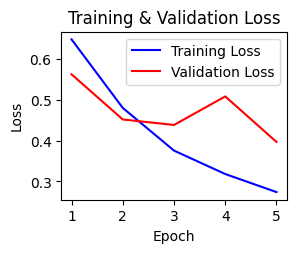

In [28]:
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

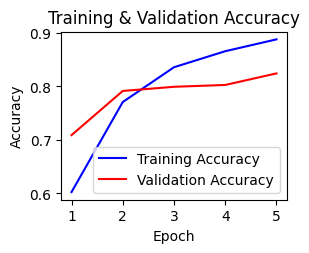

In [29]:
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

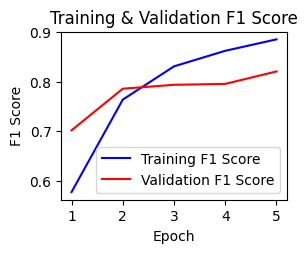

In [30]:
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1, 'b-', label='Training F1 Score')
plt.plot(epochs, val_f1, 'r-', label='Validation F1 Score')
plt.title('Training & Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()